# Coin Seminar Plant Sleep Quality Classification

## Preparation

First of all the required packages need to be installed.

In [1]:
cd /kaggle/working/

/kaggle/working


In [2]:
!pip install timm librosa torch torchvision tqdm torcheval cjm_pytorch_utils

Afterwards we will import all the required packages.

In [3]:
import random
import math
import multiprocessing
from pathlib import Path
import json

import pandas as pd
import numpy as np
import os
import librosa, librosa.display
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timezone

from PIL import Image
import torchaudio
from transformers import ASTFeatureExtractor

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import v2
import torch.nn as nn
from torch.optim.lr_scheduler import StepLR, LambdaLR, OneCycleLR
import torch.optim as optim

import timm
from timm.data import resolve_model_data_config, create_transform

from torch.amp import autocast
from torch.cuda.amp import GradScaler
from torcheval.metrics import R2Score, MulticlassAccuracy, BinaryAccuracy
from cjm_pytorch_utils.core import  get_torch_device
from tqdm.notebook import tqdm

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split

from collections import Counter

In [4]:
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

In [5]:
# Move model to GPU if available
device = get_torch_device()

We will then select the directory, where all plant recordings and labels are saved.

In [6]:
base_dir = "/kaggle/input/coin-data/COIN Projekt"

### Helper functions

We will use the following helper function to load and preprocess the audio data. The function will create a tuple of arrays containing the Mel Frequency Cepstral Coefficients, the values for the MEL Spectrograms, the filenames, and the associated subset.

In [7]:
# Load and preprocess audio data
def load_and_preprocess_data(data_dir, subsets, hop_length=512, n_mels=128, n_mfcc=20, fmax = 72, n_fft = 2048):
    """Loads and preprocesses audio data from specified directories.

    Args:
      data_dir: The directory containing the audio data.
      subsets: A list of subdirectories within `data_dir` to load data from.
      hop_length: The hop length to use when computing the Mel spectrogram.
      n_mels: The number of Mel frequency bins to use.

    Returns:
      A tuple containing:
        - A list of Mel spectrograms, one for each audio file.
        - A NumPy array of filenames corresponding to the Mel spectrograms.
        - A list of MFCCs, one for each audio file.
        - A list of subset names corresponding to the Mel spectrograms.
    """
    data = []
    filenames = []
    signals = []
    subset_names = []
    audio_dir = data_dir
    # We iterate through each subset
    for i, subset in enumerate(subsets):
      subset_dir = os.path.join(audio_dir, subset)
      for filename in os.listdir(subset_dir):
        try:
          if filename.endswith('.wav'):
              file_path = os.path.join(subset_dir, filename) # joining the path to the subset and the filename to get the full path
              print(file_path)
              audio_data, sample_rate = librosa.load(file_path, sr=None) # We load the audio data with librosa
              # Perform preprocessing (e.g., convert to Mel spectrogram)
              audio_signal = np.abs(librosa.feature.mfcc(y=audio_data, sr=sample_rate, hop_length=hop_length, n_mfcc=n_mfcc, fmax =fmax)) # Extracting Mel Frequency Cepstral Coefficients
              mel_spectrogram = librosa.feature.melspectrogram(y=audio_data, sr=sample_rate, n_mels=n_mels, hop_length=hop_length, fmax =fmax) # Extracting  Mel spectrogram
              mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max) # We convert the amplitudes to decibel scale
              filenames.append(filename) # Saving the filenames in case we need it later
              subset_names.append(subset)
              signals.append(audio_signal)
              data.append(mel_spectrogram)
        except:
          pass
    return data, np.array(filenames), signals, subset_names

## Loading the data

An den Parametern kann man rumspielen, um die Generierung von MFCC/Mel Spectrogrammen zu ändern.

In [8]:
hop_length=64*2
n_mels=128
n_mfcc=128
sr = 144
n_fft= 256
mfcc = False # False = Generiert Mel Spectrogramm
fmax = sr/2 # Default-Wert = 72

SEGMENT_DURATION = 30 # Die Länge der gespaltenen MFCC/Mel Spectrogrammen in sekunden

We will load the labels separately as a Dataframe from the sleep circle data export. It is important to note that the datetime columns "Went to bed" and "Woke up" need to be converted to the datetime with the '%Y-%m-%d %H' format.

In [9]:
sleep_circle_dir = f"{base_dir}/data/Labels/"
sleep_circle_dir

'/kaggle/input/coin-data/COIN Projekt/data/Labels/'

In [10]:
sleep_circle_data_list = []
for filename in os.listdir(sleep_circle_dir):
  sleep__circle_data = pd.read_csv(os.path.join(sleep_circle_dir, filename), delimiter= ";")
  sleep__circle_data.rename(columns={"Start": "Went to bed", "End": "Woke up"}, inplace = True)
  sleep__circle_data["Went to bed"] = pd.to_datetime(pd.to_datetime(sleep__circle_data["Went to bed"]).dt.strftime('%Y-%m-%d %H:%M:%S')).dt.tz_localize("Europe/Berlin", ambiguous=True) 
  sleep__circle_data["Woke up"] = pd.to_datetime(pd.to_datetime(sleep__circle_data["Woke up"]).dt.strftime('%Y-%m-%d %H %H:%M:%S')).dt.tz_localize("Europe/Berlin", ambiguous=True) 
  sleep__circle_data["subset_name"] = filename.split(".csv")[0]
  sleep_circle_data_list.append(sleep__circle_data)
sleep_circle_df = pd.concat(sleep_circle_data_list)
sleep_circle_df

<ipython-input-10-887ca7ea1c76>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep__circle_data["Woke up"] = pd.to_datetime(pd.to_datetime(sleep__circle_data["Woke up"]).dt.strftime('%Y-%m-%d %H %H:%M:%S')).dt.tz_localize("Europe/Berlin", ambiguous=True)
<ipython-input-10-887ca7ea1c76>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sleep__circle_data["Woke up"] = pd.to_datetime(pd.to_datetime(sleep__circle_data["Woke up"]).dt.strftime('%Y-%m-%d %H %H:%M:%S')).dt.tz_localize("Europe/Berlin", ambiguous=True)
<ipython-input-10-887ca7ea1c76>:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please s

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Notes,subset_name,Asleep after (seconds),Snore time (seconds),Coughing (per hour),Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop
0,2024-10-14 23:55:53+02:00,2024-10-15 07:31:06+02:00,78%,0%,NaN,0.0,0.0,Normal,101.2,NaN,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2024-10-16 00:44:32+02:00,2024-10-16 08:35:13+02:00,71%,84%,NaN,0.0,0.0,Normal,100.8,NaN,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2024-10-17 00:19:55+02:00,2024-10-17 07:20:44+02:00,82%,85%,NaN,0.0,0.0,Normal,100.3,Köln,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2024-10-22 01:16:03+02:00,2024-10-22 09:34:29+02:00,84%,0%,NaN,0.0,0.0,Normal,101.2,Köln,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2024-10-23 00:10:14+02:00,2024-10-23 07:41:38+02:00,83%,75%,NaN,0.0,0.0,Normal,102.6,NaN,...,NaN,Jasper,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38,2024-12-13 23:39:23+01:00,2024-12-14 07:00:18+01:00,65%,85%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,529.0,0.0,0.136085,NaN,NaN,NaN,NaN,NaN
39,2024-12-15 23:41:07+01:00,2024-12-16 07:56:30+01:00,86%,89%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,1089.0,0.0,0.000000,NaN,NaN,NaN,NaN,NaN
40,2024-12-19 23:24:05+01:00,2024-12-20 07:49:33+01:00,91%,—,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,3234.0,31.0,0.474824,NaN,NaN,NaN,NaN,NaN
41,2024-12-20 23:47:13+01:00,2024-12-21 08:36:13+01:00,74%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,Fynn,634.0,0.0,0.113422,NaN,NaN,NaN,NaN,NaN


In [11]:
sleep_circle_df["subset_name"].unique()

array(['Jasper', 'behrad', 'linus', 'Fynn'], dtype=object)

With the helper function we will load and preprocess the plant recordings.

In [12]:
data_dir = f'{base_dir}/data/Audio_Data'
subsets = ['behrad', 'linus', 'Jasper', 'Fynn']
audio_files, filenames, signals, subset_names  = load_and_preprocess_data(data_dir = data_dir, subsets = subsets, hop_length=hop_length, n_mels=n_mels, n_mfcc=n_mfcc, fmax = fmax, n_fft= n_fft)

/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1729904937567.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1731290866877.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1730861279308.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1734063115337.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1729820420488.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1731894532622.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1736132158020.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1730341004221.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1731205560774.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1736046241399.wav
/kaggle/input/coin-data/COIN Projekt/data/Audio_Data/behrad/behrad_142Hz_1730169214846.wav

From the filenames we extract the timestamp and convert it to the same format as the "Went to bed" column from the sleep circle data.

In [13]:
audio_timestamps = []
for filename in filenames:
  timestamp = filename.split("_")[-1]
  timestamp = timestamp.split(".")[0]
  timestamp = int(timestamp)
  timestamp = datetime.fromtimestamp(timestamp/1000, tz=timezone.utc).strftime('%Y-%m-%d %H:%M:%S')
  audio_timestamps.append(timestamp)

We join the arrays to a single dataframe for easier use.

In [14]:
audio_df = pd.DataFrame(data = {"timestamp": audio_timestamps, "mel_spectrogram": audio_files, "mfcc": signals, "filenames": filenames, "subset": subset_names})
audio_df['timestamp'] = pd.to_datetime(audio_df['timestamp']).dt.tz_localize("UTC", ambiguous=True) 
audio_df['timestamp']= audio_df['timestamp'].dt.tz_convert("Europe/Berlin")
audio_df

,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-26 03:08:57+02:00,"[[-9.239803, -8.823757, -8.862949, -9.260044, ...","[[105.42123, 108.44168, 118.87117, 137.13, 163...",behrad_142Hz_1729904937567.wav,behrad
1,2024-11-11 03:07:46+01:00,"[[-0.40473175, 0.0, -0.056072235, -0.47411728,...","[[91.13389, 94.25505, 104.79377, 123.16348, 14...",behrad_142Hz_1731290866877.wav,behrad
2,2024-11-06 03:47:59+01:00,"[[-0.4755535, -0.07254791, -0.13640594, -0.573...","[[90.03291, 93.00094, 103.321175, 121.33126, 1...",behrad_142Hz_1730861279308.wav,behrad
3,2024-12-13 05:11:55+01:00,"[[-0.38575745, 1.9073486e-06, -0.082653046, -0...","[[94.067986, 97.60688, 108.668846, 127.55433, ...",behrad_142Hz_1734063115337.wav,behrad
4,2024-10-25 03:40:20+02:00,"[[-16.275478, -15.718534, -15.543718, -15.6206...","[[85.96724, 89.14356, 99.797134, 118.36725, 14...",behrad_142Hz_1729820420488.wav,behrad
...,...,...,...,...,...
105,2024-10-27 23:55:02+01:00,"[[-18.695118, -18.209503, -18.121412, -18.2880...","[[83.60515, 85.786, 94.89937, 110.94671, 133.4...",fynn_142Hz_1730069702973.wav,Fynn
106,2024-10-23 23:16:25+02:00,"[[-18.70123, -18.182861, -18.141705, -18.51856...","[[69.057465, 71.81186, 81.83474, 99.55957, 125...",fynn_142Hz_1729718185899.wav,Fynn
107,2024-10-29 23:24:28+01:00,"[[-0.40259933, -1.9073486e-06, -0.06365776, -0...","[[82.410484, 85.76602, 96.76349, 116.10249, 14...",fynn_142Hz_1730240668606.wav,Fynn
108,2024-11-24 23:26:21+01:00,"[[-0.50761604, -0.10066986, -0.15892792, -0.58...","[[80.796684, 83.89443, 94.43839, 112.92157, 14...",fynn_142Hz_1732487181377.wav,Fynn


We will sort the sleep circle data and the plant recording data to merge both dataframe with eachother.

In [15]:
sleep_circle_df = sleep_circle_df.sort_values("Went to bed")

audio_df = audio_df.sort_values('timestamp')

Because the plant recording starting time and the sleep circle timestamp sometimes do not match to the exact hour, we will merge both dataframes on the "Went to bed" column and the "timestamp" column with a range of 3 hours.

In [16]:
concat_arr = []
for subset in subsets:
  subset_df = audio_df[audio_df["subset"] == subset]
  sleep_circle_subset_df = sleep_circle_df[sleep_circle_df["subset_name"] == subset]
  subset_merged_df = pd.merge_asof(sleep_circle_subset_df, subset_df, left_on="Went to bed", right_on ="timestamp", direction='nearest', tolerance=pd.Timedelta('1 hour'))
  concat_arr.append(subset_merged_df)
merged_df = pd.concat(concat_arr)
merged_df["Asleep after (seconds)"] = merged_df["Asleep after (seconds)"].fillna(merged_df["Time before sleep (seconds)"])

We drop all rows which have null values for the mel_spectrogram. Furthermore we convert the sleep quality column to the float data type ranging from 0 to 1.

In [17]:
merged_df[merged_df["Asleep after (seconds)"].isna()]

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset


In [18]:
merged_df = merged_df.dropna(subset = ["mel_spectrogram"]).reset_index(drop=True)
#merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", ""))/100)
#merged_df["Sleep Quality"] = merged_df["Sleep Quality"].apply(lambda x: float(x.replace("%", "")))
merged_df

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:37:30+02:00,2024-10-24 11:30:33+02:00,87%,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 03:36:04+02:00,"[[-19.418148, -18.928947, -18.880512, -19.1727...","[[105.89213, 108.88713, 119.24658, 137.36229, ...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:12:45+02:00,2024-10-26 10:39:41+02:00,77%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 03:08:57+02:00,"[[-9.239803, -8.823757, -8.862949, -9.260044, ...","[[105.42123, 108.44168, 118.87117, 137.13, 163...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:06:01+01:00,2024-10-27 11:29:12+01:00,74%,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 03:05:49+01:00,"[[-18.559975, -18.129017, -18.165823, -18.5934...","[[80.83722, 84.02769, 94.724625, 113.45193, 14...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:34:17+01:00,2024-10-29 11:30:32+01:00,80%,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 03:33:34+01:00,"[[-19.095901, -18.6701, -18.695759, -19.075895...","[[94.54935, 97.3934, 107.547104, 125.353516, 1...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:20:53+01:00,2024-10-31 10:36:27+01:00,79%,92%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 03:16:44+01:00,"[[-19.701931, -19.191357, -19.157442, -19.5022...","[[117.08586, 118.93325, 127.481865, 142.51964,...",behrad_142Hz_1730341004221.wav,behrad
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,2024-11-19 23:51:54+01:00,2024-11-20 08:12:04+01:00,90%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-19 23:46:17+01:00,"[[-0.54564095, -0.1419239, -0.20315552, -0.635...","[[81.872696, 85.1013, 95.83306, 114.610695, 14...",fynn_142Hz_1732056377456.wav,Fynn
97,2024-11-20 23:51:16+01:00,2024-11-21 08:30:45+01:00,89%,94%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-20 23:51:00+01:00,"[[-2.4079132, -2.0246315, -2.1094818, -2.56867...","[[65.02767, 66.32009, 74.43806, 89.3558, 110.7...",fynn_142Hz_1732143060447.wav,Fynn
98,2024-11-21 23:27:36+01:00,2024-11-22 08:06:43+01:00,94%,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-21 23:27:10+01:00,"[[-0.4921608, -0.090099335, -0.15368271, -0.58...","[[80.96805, 84.117165, 94.86617, 113.95064, 14...",fynn_142Hz_1732228030045.wav,Fynn
99,2024-11-24 23:31:23+01:00,2024-11-25 08:07:34+01:00,89%,99%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-24 23:26:21+01:00,"[[-0.50761604, -0.10066986, -0.15892792, -0.58...","[[80.796684, 83.89443, 94.43839, 112.92157, 14...",fynn_142Hz_1732487181377.wav,Fynn


In [19]:
merged_df[merged_df["subset"]== "behrad"]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
0,2024-10-24 03:37:30+02:00,2024-10-24 11:30:33+02:00,87%,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 03:36:04+02:00,"[[-19.418148, -18.928947, -18.880512, -19.1727...","[[105.89213, 108.88713, 119.24658, 137.36229, ...",behrad_142Hz_1729733764243.wav,behrad
1,2024-10-26 03:12:45+02:00,2024-10-26 10:39:41+02:00,77%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-26 03:08:57+02:00,"[[-9.239803, -8.823757, -8.862949, -9.260044, ...","[[105.42123, 108.44168, 118.87117, 137.13, 163...",behrad_142Hz_1729904937567.wav,behrad
2,2024-10-27 03:06:01+01:00,2024-10-27 11:29:12+01:00,74%,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-27 03:05:49+01:00,"[[-18.559975, -18.129017, -18.165823, -18.5934...","[[80.83722, 84.02769, 94.724625, 113.45193, 14...",behrad_142Hz_1729994749595.wav,behrad
3,2024-10-29 03:34:17+01:00,2024-10-29 11:30:32+01:00,80%,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 03:33:34+01:00,"[[-19.095901, -18.6701, -18.695759, -19.075895...","[[94.54935, 97.3934, 107.547104, 125.353516, 1...",behrad_142Hz_1730169214846.wav,behrad
4,2024-10-31 03:20:53+01:00,2024-10-31 10:36:27+01:00,79%,92%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 03:16:44+01:00,"[[-19.701931, -19.191357, -19.157442, -19.5022...","[[117.08586, 118.93325, 127.481865, 142.51964,...",behrad_142Hz_1730341004221.wav,behrad
5,2024-11-01 03:39:20+01:00,2024-11-01 09:51:22+01:00,61%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-01 03:02:41+01:00,"[[-17.845621, -17.543833, -17.737858, -18.3419...","[[90.47631, 92.756004, 101.905556, 117.84708, ...",behrad_142Hz_1730426561089.wav,behrad
6,2024-11-02 03:23:44+01:00,2024-11-02 11:00:35+01:00,66%,91%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-02 03:07:28+01:00,"[[-22.086075, -21.341011, -20.910055, -20.6491...","[[160.93509, 160.7147, 165.90723, 175.21454, 1...",behrad_142Hz_1730513248148.wav,behrad
7,2024-11-03 03:24:30+01:00,2024-11-03 09:53:34+01:00,66%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-03 02:56:33+01:00,"[[-0.101234436, 0.0, -0.44932556, -1.3835335, ...","[[42.431877, 38.706886, 27.1358, 6.812357, 24....",behrad_142Hz_1730598993365.wav,behrad
8,2024-11-05 02:43:12+01:00,2024-11-05 11:30:10+01:00,84%,86%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-05 02:42:10+01:00,"[[-0.4043522, 0.0, -0.06529999, -0.509943, -1....","[[88.62068, 91.66944, 102.10112, 120.278435, 1...",behrad_142Hz_1730770930651.wav,behrad
9,2024-11-06 03:49:09+01:00,2024-11-06 08:46:03+01:00,53%,74%,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 03:47:59+01:00,"[[-0.4755535, -0.07254791, -0.13640594, -0.573...","[[90.03291, 93.00094, 103.321175, 121.33126, 1...",behrad_142Hz_1730861279308.wav,behrad


In [20]:
merged_df[merged_df["subset"]== "linus"]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Alertness score,Alertness reaction time (seconds),Alertness accuracy,Wake up window start,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset
24,2024-10-24 00:16:20+02:00,2024-10-24 08:11:04+02:00,86%,91%,NaN,0.0,4919.0,Normal,100.7,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-24 00:16:27+02:00,"[[-0.39348793, -1.9073486e-06, -0.07159233, -0...","[[79.17817, 80.8647, 89.17679, 104.13771, 125....",linus_142Hz_1729721787072.wav,linus
25,2024-10-29 01:52:08+01:00,2024-10-29 08:07:10+01:00,68%,0%,NaN,0.0,1520.0,No alarm,100.1,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-29 01:54:10+01:00,"[[-0.7161045, -0.3088131, -0.36631584, -0.7936...","[[86.46879, 87.87329, 94.5636, 105.324844, 119...",linus_142Hz_1730163250153.wav,linus
26,2024-10-30 00:27:53+01:00,2024-10-30 07:33:06+01:00,78%,84%,NaN,0.0,1161.0,No alarm,100.2,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-30 00:26:34+01:00,"[[-1.4670753, -1.0664577, -1.1294689, -1.56154...","[[79.22386, 80.19669, 87.807335, 102.11141, 12...",linus_142Hz_1730244394101.wav,linus
27,2024-10-31 00:26:26+01:00,2024-10-31 09:20:55+01:00,97%,84%,NaN,0.0,5885.0,Normal,100.4,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-10-31 00:24:37+01:00,"[[-0.4051113, 0.0, -0.058994293, -0.48799133, ...","[[92.24178, 93.25644, 100.84327, 115.052345, 1...",linus_142Hz_1730330677318.wav,linus
28,2024-11-04 00:09:58+01:00,2024-11-04 07:55:34+01:00,83%,0%,NaN,0.0,1249.0,No alarm,100.5,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-04 00:06:19+01:00,"[[-0.8403988, -0.4341755, -0.4931965, -0.92376...","[[91.33311, 91.11537, 97.81424, 111.404854, 13...",linus_142Hz_1730675179245.wav,linus
29,2024-11-05 00:32:53+01:00,2024-11-05 07:56:32+01:00,81%,97%,NaN,0.0,2694.0,No alarm,100.0,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-05 00:27:16+01:00,"[[-2.1257038, -1.7210579, -1.7803192, -2.20997...","[[88.14609, 90.693695, 100.45517, 117.67018, 1...",linus_142Hz_1730762836228.wav,linus
30,2024-11-06 00:41:02+01:00,2024-11-06 08:04:52+01:00,78%,97%,NaN,0.0,2932.0,No alarm,100.2,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-06 00:41:50+01:00,"[[-1.6223564, -1.2357674, -1.3204651, -1.78620...","[[93.54681, 94.40082, 101.40003, 114.161705, 1...",linus_142Hz_1730850110871.wav,linus
31,2024-11-07 00:21:02+01:00,2024-11-07 07:54:43+01:00,73%,97%,NaN,0.0,0.0,No alarm,100.8,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-07 00:18:28+01:00,"[[-13.448704, -12.57468, -12.035843, -11.71370...","[[162.22662, 158.10994, 159.50563, 165.8795, 1...",linus_142Hz_1730935108787.wav,linus
32,2024-11-07 23:21:17+01:00,2024-11-08 07:30:46+01:00,83%,94%,NaN,0.0,4353.0,No alarm,100.7,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-07 23:22:04+01:00,"[[-8.368227, -7.9534607, -8.004391, -8.457882,...","[[110.64636, 112.63808, 121.22587, 135.9464, 1...",linus_142Hz_1731018124056.wav,linus
33,2024-11-10 00:33:25+01:00,2024-11-10 08:46:50+01:00,86%,84%,NaN,0.0,2804.0,No alarm,100.1,Solingen,...,NaN,NaN,NaN,NaN,NaN,2024-11-10 00:32:12+01:00,"[[-0.6211338, -0.21787453, -0.28046608, -0.715...","[[80.21368, 82.977356, 93.02156, 110.659035, 1...",linus_142Hz_1731195132023.wav,linus


In [21]:
(merged_df.loc[0,"timestamp"]- merged_df.loc[0, "Went to bed"]).total_seconds()

-86.0

In [22]:
( merged_df.loc[0, "Went to bed"]-merged_df.loc[0,"timestamp"])

Timedelta('0 days 00:01:26')

In [23]:
hop_length / sr

0.8888888888888888

### Processing Mel Spectrogramm (Trim, Split into "Awake and Sleep", Split into smaller parts)

In [24]:
def trim_mfcc(x, mfcc = True):
    # Calculate the time per frame
    time_per_frame = hop_length / sr
    # Calculate trim start time
    trim_start_time_delta = x["Went to bed"] - x["timestamp"]
    trim_seconds = trim_start_time_delta.total_seconds()

    if trim_seconds > 0:
        frames_to_trim = int(trim_seconds / time_per_frame)  # frames to trim
        if mfcc:
            x["trimmed_spectrogram"] = x["mfcc"][:, frames_to_trim:]
            x["Asleep after (seconds) trimmed"] = x["Asleep after (seconds)"]
        else:
            x["trimmed_spectrogram"] = x["mel_spectrogram"][:, frames_to_trim:]
            x["Asleep after (seconds) trimmed"] = x["Asleep after (seconds)"]
    else:
        if mfcc:
            x["trimmed_spectrogram"] = x["mfcc"]
            x["Asleep after (seconds) trimmed"] = x["Asleep after (seconds)"] + trim_seconds
        else:
            x["trimmed_spectrogram"] = x["mel_spectrogram"]
            x["Asleep after (seconds) trimmed"] = x["Asleep after (seconds)"] + trim_seconds
            print(f'Trimmed: {x["Asleep after (seconds) trimmed"]}')
            print(f'Without trimming: {x["Asleep after (seconds)"]}')

    return x

In [25]:
merged_df = merged_df.apply(lambda x: trim_mfcc(x, mfcc= mfcc), axis = 1)

Trimmed: 832.0
Without trimming: 883.0
Trimmed: 562.7
Without trimming: 569.7
Trimmed: 928.0999999999999
Without trimming: 1050.1
Trimmed: 750.9
Without trimming: 798.9
Trimmed: 540.4
Without trimming: 587.4
Trimmed: 436.9
Without trimming: 502.9
Trimmed: 550.9
Without trimming: 576.9
Trimmed: 557.7
Without trimming: 583.7
Trimmed: 615.2
Without trimming: 683.2
Trimmed: 551.9
Without trimming: 565.9
Trimmed: 395.7
Without trimming: 449.7


In [26]:
def split_spectrogram_into_sleep_parts(x):
    # Calculate the time per frame
    time_per_frame = hop_length / sr

    frames_per_minute = int((1 * 60) / time_per_frame)  # 1 minute in seconds
    asleep_after_seconds = x["Asleep after (seconds) trimmed"]  # Seconds before considered asleep
    asleep_after_frames = int(asleep_after_seconds / time_per_frame)  # convert seconds to frames
    asleep_30min_frames = frames_per_minute*20
 
    # First split the MFCC/Mel Spectrogram into Asleep and 30Min Awake parts
    awake_spectrogram = x["trimmed_spectrogram"][:, :asleep_after_frames]
    asleep_spectrogram = x["trimmed_spectrogram"][:, asleep_after_frames + asleep_30min_frames*3: asleep_after_frames + asleep_30min_frames*4]
    x["splitted_parts"] = [awake_spectrogram, asleep_spectrogram]
    x["label"] = [0,1]
  
    return x

In [27]:
merged_df_split_parts = merged_df.apply(lambda x: split_spectrogram_into_sleep_parts(x), axis = 1).explode(['splitted_parts','label'])

In [28]:
def split_spectrogram_into_minutes(x, segment_duration = 60):

  # Calculate the time per frame
  time_per_frame = hop_length / sr
  # Calculate frames per minute
  frames_per_minute = int((segment_duration) / time_per_frame)  # 1 minute in seconds

  # Total number of frames
  total_frames = x["splitted_parts"].shape[1]

  # Split the MFCC into minute parts
  parts_split_in_minutes = []
  start_frame = 0
  while start_frame < total_frames:
      # Determine end_frame for this segment
      end_frame = start_frame + frames_per_minute
      # Extract this part and add to the list
      parts_split_in_minutes.append(x["splitted_parts"][:, start_frame:end_frame])
      
      start_frame = end_frame
  return parts_split_in_minutes

In [29]:
merged_df_split_parts["spectrogram_split_in_minutes"] = merged_df_split_parts.apply(lambda x: split_spectrogram_into_minutes(x, segment_duration = SEGMENT_DURATION), axis = 1)
merged_df_split_parts

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pan

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,timestamp,mel_spectrogram,mfcc,filenames,subset,trimmed_spectrogram,Asleep after (seconds) trimmed,splitted_parts,label,spectrogram_split_in_minutes
0,2024-10-24 03:37:30+02:00,2024-10-24 11:30:33+02:00,87%,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-24 03:36:04+02:00,"[[-19.418148, -18.928947, -18.880512, -19.1727...","[[105.89213, 108.88713, 119.24658, 137.36229, ...",behrad_142Hz_1729733764243.wav,behrad,"[[-19.504986, -19.086205, -18.835033, -18.7645...",3879.0,"[[-19.504986, -19.086205, -18.835033, -18.7645...",0,"[[[-19.504986, -19.086205, -18.835033, -18.764..."
0,2024-10-24 03:37:30+02:00,2024-10-24 11:30:33+02:00,87%,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-24 03:36:04+02:00,"[[-19.418148, -18.928947, -18.880512, -19.1727...","[[105.89213, 108.88713, 119.24658, 137.36229, ...",behrad_142Hz_1729733764243.wav,behrad,"[[-19.504986, -19.086205, -18.835033, -18.7645...",3879.0,"[[-20.443752, -20.324953, -20.21942, -20.12927...",1,"[[[-20.443752, -20.324953, -20.21942, -20.1292..."
1,2024-10-26 03:12:45+02:00,2024-10-26 10:39:41+02:00,77%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-26 03:08:57+02:00,"[[-9.239803, -8.823757, -8.862949, -9.260044, ...","[[105.42123, 108.44168, 118.87117, 137.13, 163...",behrad_142Hz_1729904937567.wav,behrad,"[[-10.980192, -10.964737, -10.922941, -10.8501...",1877.0,"[[-10.980192, -10.964737, -10.922941, -10.8501...",0,"[[[-10.980192, -10.964737, -10.922941, -10.850..."
1,2024-10-26 03:12:45+02:00,2024-10-26 10:39:41+02:00,77%,90%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-26 03:08:57+02:00,"[[-9.239803, -8.823757, -8.862949, -9.260044, ...","[[105.42123, 108.44168, 118.87117, 137.13, 163...",behrad_142Hz_1729904937567.wav,behrad,"[[-10.980192, -10.964737, -10.922941, -10.8501...",1877.0,"[[-10.148542, -10.155449, -10.194923, -10.2546...",1,"[[[-10.148542, -10.155449, -10.194923, -10.254..."
2,2024-10-27 03:06:01+01:00,2024-10-27 11:29:12+01:00,74%,83%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-10-27 03:05:49+01:00,"[[-18.559975, -18.129017, -18.165823, -18.5934...","[[80.83722, 84.02769, 94.724625, 113.45193, 14...",behrad_142Hz_1729994749595.wav,behrad,"[[-22.048775, -22.002235, -21.857338, -21.6491...",603.0,"[[-22.048775, -22.002235, -21.857338, -21.6491...",0,"[[[-22.048775, -22.002235, -21.857338, -21.649..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,2024-11-21 23:27:36+01:00,2024-11-22 08:06:43+01:00,94%,93%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-11-21 23:27:10+01:00,"[[-0.4921608, -0.090099335, -0.15368271, -0.58...","[[80.96805, 84.117165, 94.86617, 113.95064, 14...",fynn_142Hz_1732228030045.wav,Fynn,"[[-2.6265545, -2.6287975, -2.6267567, -2.62075...",2491.0,"[[-2.6535797, -2.6571045, -2.659254, -2.656753...",1,"[[[-2.6535797, -2.6571045, -2.659254, -2.65675..."
99,2024-11-24 23:31:23+01:00,2024-11-25 08:07:34+01:00,89%,99%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-11-24 23:26:21+01:00,"[[-0.50761604, -0.10066986, -0.15892792, -0.58...","[[80.796684, 83.89443, 94.43839, 112.92157, 14...",fynn_142Hz_1732487181377.wav,Fynn,"[[-2.6489964, -2.6496582, -2.64991, -2.6495934...",929.0,"[[-2.6489964, -2.6496582, -2.64991, -2.6495934...",0,"[[[-2.6489964, -2.6496582, -2.64991, -2.649593..."
99,2024-11-24 23:31:23+01:00,2024-11-25 08:07:34+01:00,89%,99%,NaN,NaN,NaN,NaN,NaN,NaN,...,2024-11-24 23:26:21+01:00,"[[-0.50761604, -0.10066986, -0.15892792, -0.58...","[[80.796684, 83.89443, 94.43839, 112.92157, 14...",fynn_142Hz_1732487181377.wav,Fynn,"[[-2.6489964, -2.6496582, -2.64991, -2.6495934...",929.0,"[[-2.650278, -2.6504383, -2.651083, -2.651722,...",1,"[[[-2.650278, -2.6504383, -2.651083, -2.651722..."
100,2025-01-07 23:39:30+01:00,2025-01-08 08:03:13+01:00,93%,—,NaN,NaN,NaN,NaN,NaN,NaN,...,2025-01-07 23:39:16+01:00,"[[-1.6134853, -1.2113228, -1.2759495, -1.71397...","[[81.60341, 84.82519, 95.62163, 114.65656, 143...",fynn_142Hz_1736289556471.wav,Fynn,"[[-3.7614193, -3.760456,

In [30]:
merged_df_split_parts = merged_df_split_parts.explode("spectrogram_split_in_minutes")

In [31]:
merged_df_split_parts.reset_index(drop=True, inplace=True)

In [32]:
merged_df_split_parts.groupby("label").count()/len(merged_df_split_parts)

,Went to bed,Woke up,Sleep Quality,Regularity,Mood,Heart rate (bpm),Steps,Alarm mode,Air Pressure (Pa),City,...,Wake up window stop,timestamp,mel_spectrogram,mfcc,filenames,subset,trimmed_spectrogram,Asleep after (seconds) trimmed,splitted_parts,spectrogram_split_in_minutes
label,,,,,,,,,,,,,,,,,,,,,
0,0.50306,0.50306,0.50306,0.50306,0.0,0.247090,0.247090,0.247090,0.247090,0.198248,...,0.0,0.50306,0.50306,0.50306,0.50306,0.50306,0.50306,0.50306,0.50306,0.50306
1,0.49694,0.49694,0.49694,0.49694,0.0,0.265691,0.265691,0.265691,0.265691,0.246010,...,0.0,0.49694,0.49694,0.49694,0.49694,0.49694,0.49694,0.49694,0.49694,0.49694


In [33]:
merged_df_split_parts = merged_df_split_parts[["spectrogram_split_in_minutes", "label", "subset"]]

## Visualizing the data

In [34]:
merged_df_split_parts["spectrogram_split_in_minutes"][0].shape

(128, 33)

In [35]:
merged_df_split_parts["spectrogram_split_in_minutes"][0]

array([[-19.504986, -19.086205, -18.835033, ..., -20.515612, -20.573977,
        -20.63611 ],
       [-39.04737 , -38.086643, -37.409756, ..., -54.97378 , -54.92884 ,
        -54.24204 ],
       [-37.88485 , -36.037476, -34.83412 , ..., -53.101444, -53.37629 ,
        -53.852566],
       ...,
       [-72.63732 , -72.05983 , -71.54884 , ..., -74.153854, -73.37764 ,
        -72.90258 ],
       [-73.76335 , -73.3487  , -73.07547 , ..., -80.      , -79.34746 ,
        -77.797386],
       [-80.      , -80.      , -80.      , ..., -80.      , -80.      ,
        -80.      ]], dtype=float32)

We plot the MEL-Spectrogram and the MFCC with the librosa.display.specshow function (https://librosa.org/doc/main/generated/librosa.display.specshow.html). All values are plotted in hz units but the scale differs (MEL-Spectrogram uses mel scale while MFCC uses hz).

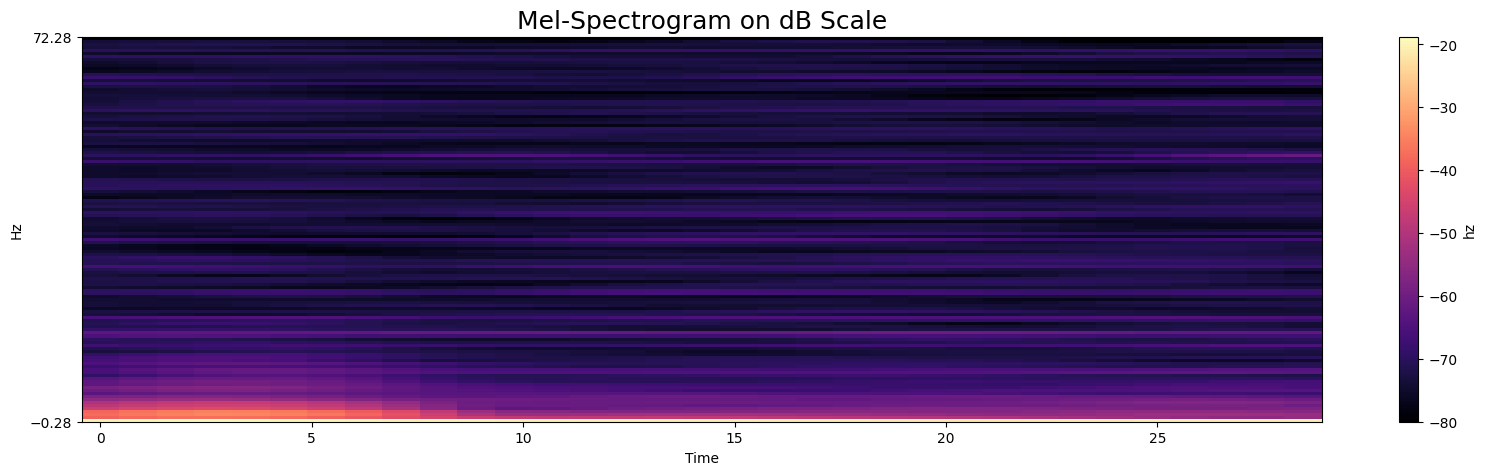

In [36]:
plt.figure(figsize=(20, 5))
librosa.display.specshow(merged_df_split_parts["spectrogram_split_in_minutes"][0], x_axis='time',
                         y_axis='mel', sr=sr, cmap= "magma", hop_length=hop_length)
plt.colorbar(label="hz")
plt.title('Mel-Spectrogram on dB Scale', fontdict=dict(size=18))
plt.show()

Bilder werden in der folgenden Zelle auf der Disk gespeichert. Dauert etwas lange.

Falls einer das umschreiben will, kann er das sehr gerne tun. :)

In [37]:
import os
output_dir = "/kaggle/working/spectrogram_images"

# Create directory if it does not exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Create RGB image and save it on disk
def create_image(x, output_dir = output_dir):
    fig = plt.figure(figsize=(6, 6), num=1, clear=True)
    librosa.display.specshow(x["spectrogram_split_in_minutes"], sr=sr, hop_length=hop_length, cmap='magma')
    plt.axis("off")
    image_filename= f'{output_dir}/{x.name}.png'
    plt.savefig(image_filename, bbox_inches='tight', pad_inches=0)
    plt.close(fig)
    return image_filename

In [38]:
merged_df_split_parts["image_filename"] = merged_df_split_parts.apply(lambda x: create_image(x, output_dir = output_dir), axis = 1)

In [39]:
merged_df_split_parts["image_filename"]

0          /kaggle/working/spectrogram_images/0.png
1          /kaggle/working/spectrogram_images/1.png
2          /kaggle/working/spectrogram_images/2.png
3          /kaggle/working/spectrogram_images/3.png
4          /kaggle/working/spectrogram_images/4.png
                           ...                     
8328    /kaggle/working/spectrogram_images/8328.png
8329    /kaggle/working/spectrogram_images/8329.png
8330    /kaggle/working/spectrogram_images/8330.png
8331    /kaggle/working/spectrogram_images/8331.png
8332    /kaggle/working/spectrogram_images/8332.png
Name: image_filename, Length: 8333, dtype: object

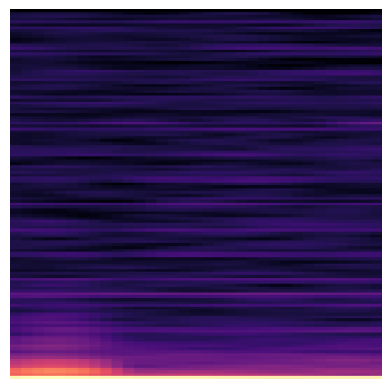

In [40]:
import cv2
import matplotlib.pyplot as plt


image = cv2.imread(merged_df_split_parts.loc[0, "image_filename"])  # OpenCV loads images in BGR format

# Convert BGR to RGB (for correct colors in Matplotlib)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Show the image
plt.imshow(image_rgb)
plt.axis("off")  # Hide axis
plt.show()

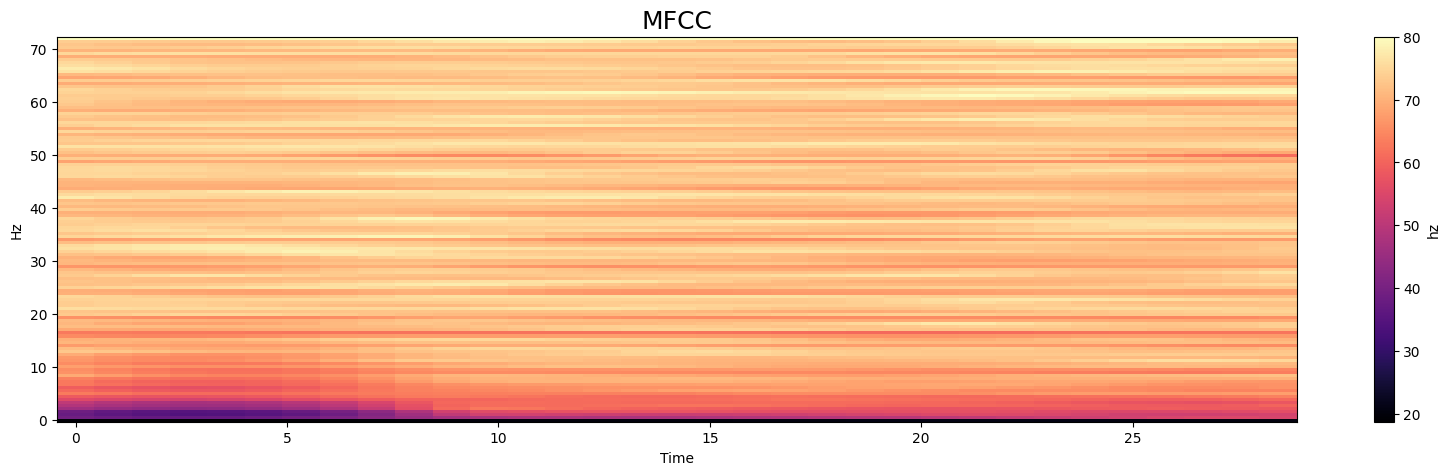

In [41]:
# Only important when using MFCC

plt.figure(figsize=(20, 5))
librosa.display.specshow(np.abs(merged_df_split_parts["spectrogram_split_in_minutes"][0]), x_axis='time',
                         y_axis = "hz", sr=sr, cmap= "magma", hop_length=hop_length)
plt.colorbar(label = "hz")
plt.title("MFCC", fontdict=dict(size=18))
plt.show()

We will also visualize the waveform to look at the peaks of amiplitudes (https://librosa.org/doc/main/generated/librosa.display.waveshow.html).

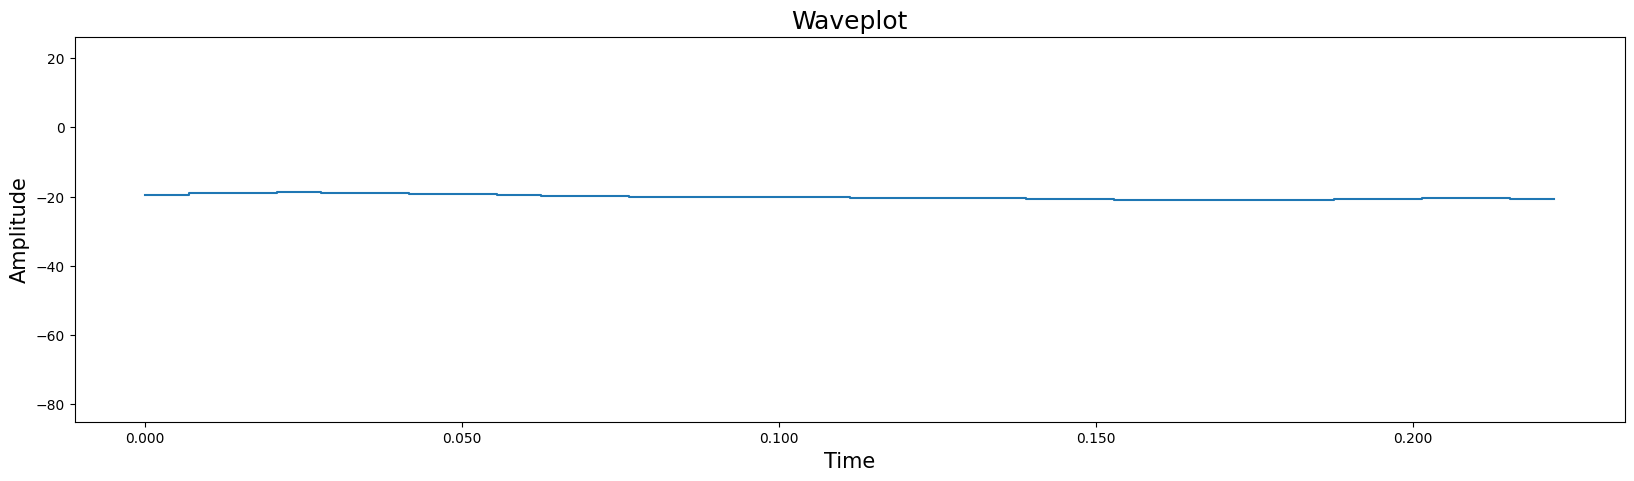

In [42]:
plt.figure(figsize=(20, 5))
librosa.display.waveshow(merged_df_split_parts["spectrogram_split_in_minutes"][0], sr = 144)
plt.title("Waveplot", fontdict=dict(size=18))
plt.xlabel("Time", fontdict=dict(size=15))
plt.ylabel("Amplitude", fontdict=dict(size=15))
plt.show()

## Training Image Classification Neural Networks

## Model loading

In [43]:
# Load a pretrained model from timm
num_classes = 1
#model = timm.create_model('resnet18', pretrained=True)
# model = timm.create_model("eva02_base_patch14_448.mim_in22k_ft_in22k_in1k", pretrained=True, num_classes=2)
# model = timm.create_model("resnet18.a1_in1k", pretrained=True, num_classes=2)
model = timm.create_model('tiny_vit_21m_224.dist_in22k_ft_in1k', pretrained=True, num_classes=num_classes)
#model = timm.create_model('tf_efficientnetv2_m.in21k_ft_in1k', pretrained=True, num_classes=num_classes)
#model.fc = nn.Sequential(nn.Dropout(0.5),nn.Linear(model.fc.in_features, 2))
model

TinyVit(
  (patch_embed): PatchEmbed(
    (conv1): ConvNorm(
      (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (act): GELU(approximate='none')
    (conv2): ConvNorm(
      (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (stages): Sequential(
    (0): ConvLayer(
      (blocks): Sequential(
        (0): MBConv(
          (conv1): ConvNorm(
            (conv): Conv2d(96, 384, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
          (act1): GELU(approximate='none')
          (conv2): ConvNorm(
            (conv): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=384, bias=Fals

In [44]:
model.pretrained_cfg

{'url': '',
 'hf_hub_id': 'timm/tiny_vit_21m_224.dist_in22k_ft_in1k',
 'architecture': 'tiny_vit_21m_224',
 'tag': 'dist_in22k_ft_in1k',
 'custom_load': False,
 'input_size': (3, 224, 224),
 'fixed_input_size': False,
 'interpolation': 'bicubic',
 'crop_pct': 0.95,
 'crop_mode': 'center',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'num_classes': 1000,
 'pool_size': (7, 7),
 'first_conv': 'patch_embed.conv1.conv',
 'classifier': 'head.fc'}

### Dataset

We create a custom dataframe object for the mfcc or the melspectrogram.

In [45]:
class AudioDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert("RGB")
        label_dtype = torch.float
        label = torch.tensor(self.labels[idx], dtype=label_dtype)

        if self.transform:
            image = self.transform(image)

        return image, label

data_config = resolve_model_data_config(model)


train_transform = v2.Compose([ 
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize(size = data_config['input_size'][1:], interpolation = v2.InterpolationMode.BICUBIC),  # Match input size expected by the model
    v2.RandomRotation(20),
    v2.RandomHorizontalFlip(),
    v2.ColorJitter(brightness=0.2, contrast=0.2),
    v2.Normalize(mean=data_config['mean'], std=data_config['std'])
    
])

#train_transform = create_transform(**data_config, no_aug=False, is_training=True)
valid_transform = create_transform(**data_config, no_aug=True, is_training=False)



In [46]:
train_transform

Compose(
      ToImage()
      ToDtype(scale=True)
      Resize(size=[224, 224], interpolation=InterpolationMode.BICUBIC, antialias=True)
      RandomRotation(degrees=[-20.0, 20.0], interpolation=InterpolationMode.NEAREST, expand=False, fill=0)
      RandomHorizontalFlip(p=0.5)
      ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2))
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], inplace=False)
)

In [47]:
valid_transform

Compose(
    Resize(size=235, interpolation=bicubic, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    MaybeToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

First we split the dataframe into train and validation set.

In [48]:
def stratified_split_by_subject_and_label(metadata_df, train_size=0.8, random_state=42):
    """
    Führt einen stratifizierten Split der Daten durch, wobei für jeden Probanden und jedes Label
    ein bestimmter Prozentsatz im Trainingsdatensatz und der Rest im Validierungsdatensatz landet.
    
    Args:
        metadata_df (pd.DataFrame): DataFrame mit den Metadaten
        train_size (float): Anteil der Daten, die für das Training verwendet werden sollen (0-1)
        random_state (int): Seed für die Zufallszahlengenerierung
        
    Returns:
        train_df (pd.DataFrame): DataFrame mit den Trainingsdaten
        val_df (pd.DataFrame): DataFrame mit den Validierungsdaten
    """
    
    # Setze den Seed für Reproduzierbarkeit
    np.random.seed(random_state)

    # binary_label_map = {
    #     0: 0,  # Awake → 0
    #     1: 1,  # Light Sleep → 1
    #     2: 1   # Deep Sleep → 1
    # }
    
    # Erstelle eine Kopie des DataFrames, um die Originaldaten nicht zu verändern
    df = metadata_df.copy()

    
    
    # Erstelle eine Kombination aus Proband und Label als Stratifizierungsvariable
    df['subject_label'] = df['subset'] + '_' + df['label'].astype(str)
    
    # Initialisiere leere DataFrames für Trainings- und Validierungsdaten
    train_dfs = []
    val_dfs = []
    
    # Für jede Kombination aus Proband und Label
    for group, group_df in df.groupby('subject_label'):
        # Teile die Daten dieser Gruppe in Trainings- und Validierungsdaten auf
        if len(group_df) > 1:  # Stelle sicher, dass genug Daten für eine Aufteilung vorhanden sind
            train_group, val_group = train_test_split(
                group_df, 
                train_size=train_size, 
                random_state=random_state,
                shuffle=True
            )
            train_dfs.append(train_group)
            val_dfs.append(val_group)
        else:
            # Wenn nur ein Datenpunkt vorhanden ist, füge ihn dem Trainingsdatensatz hinzu
            train_dfs.append(group_df)
    
    # Kombiniere die Trainings- und Validierungsdaten
    train_df = pd.concat(train_dfs, ignore_index=True)
    val_df = pd.concat(val_dfs, ignore_index=True) if val_dfs else pd.DataFrame(columns=df.columns)
    
    # Entferne die temporäre Stratifizierungsvariable
    train_df = train_df.drop('subject_label', axis=1)
    val_df = val_df.drop('subject_label', axis=1)
    
    # Überprüfe die Verteilung der Probanden und Labels
    print("Verteilung der Probanden:")
    print(f"Training: {train_df['subset'].value_counts().to_dict()}")
    print(f"Validierung: {val_df['subset'].value_counts().to_dict()}")
    
    print("\nVerteilung der Labels:")
    print(f"Training: {train_df['label'].value_counts().to_dict()}")
    print(f"Validierung: {val_df['label'].value_counts().to_dict()}")
    
    # Überprüfe die Verteilung für jede Kombination aus Proband und Label
    print("\nVerteilung für jede Kombination aus Proband und Label:")
    for subject in df['subset'].unique():
        for label in df['label'].unique():
            train_count = len(train_df[(train_df['subset'] == subject) & (train_df['label'] == label)])
            val_count = len(val_df[(val_df['subset'] == subject) & (val_df['label'] == label)])
            total = train_count + val_count
            if total > 0:
                train_percent = train_count / total * 100
                print(f"Proband: {subject}, Label: {label} - Training: {train_count} ({train_percent:.1f}%), Validierung: {val_count} ({100-train_percent:.1f}%)")
    
    return train_df, val_df

In [49]:
train_df, val_test_df =  stratified_split_by_subject_and_label(merged_df_split_parts, train_size=0.7, random_state=42)

Verteilung der Probanden:
Training: {'linus': 1804, 'behrad': 1603, 'Fynn': 1237, 'Jasper': 1185}
Validierung: {'linus': 775, 'behrad': 689, 'Fynn': 531, 'Jasper': 509}

Verteilung der Labels:
Training: {0: 2932, 1: 2897}
Validierung: {0: 1260, 1: 1244}

Verteilung für jede Kombination aus Proband und Label:
Proband: behrad, Label: 0 - Training: 915 (70.0%), Validierung: 393 (30.0%)
Proband: behrad, Label: 1 - Training: 688 (69.9%), Validierung: 296 (30.1%)
Proband: linus, Label: 0 - Training: 628 (69.9%), Validierung: 270 (30.1%)
Proband: linus, Label: 1 - Training: 1176 (70.0%), Validierung: 505 (30.0%)
Proband: Jasper, Label: 0 - Training: 812 (69.9%), Validierung: 349 (30.1%)
Proband: Jasper, Label: 1 - Training: 373 (70.0%), Validierung: 160 (30.0%)
Proband: Fynn, Label: 0 - Training: 577 (69.9%), Validierung: 248 (30.1%)
Proband: Fynn, Label: 1 - Training: 660 (70.0%), Validierung: 283 (30.0%)


In [50]:
val_df, test_df =  stratified_split_by_subject_and_label(val_test_df, train_size=0.5, random_state=42)

Verteilung der Probanden:
Training: {'linus': 387, 'behrad': 344, 'Fynn': 265, 'Jasper': 254}
Validierung: {'linus': 388, 'behrad': 345, 'Fynn': 266, 'Jasper': 255}

Verteilung der Labels:
Training: {0: 629, 1: 621}
Validierung: {0: 631, 1: 623}

Verteilung für jede Kombination aus Proband und Label:
Proband: Fynn, Label: 0 - Training: 124 (50.0%), Validierung: 124 (50.0%)
Proband: Fynn, Label: 1 - Training: 141 (49.8%), Validierung: 142 (50.2%)
Proband: Jasper, Label: 0 - Training: 174 (49.9%), Validierung: 175 (50.1%)
Proband: Jasper, Label: 1 - Training: 80 (50.0%), Validierung: 80 (50.0%)
Proband: behrad, Label: 0 - Training: 196 (49.9%), Validierung: 197 (50.1%)
Proband: behrad, Label: 1 - Training: 148 (50.0%), Validierung: 148 (50.0%)
Proband: linus, Label: 0 - Training: 135 (50.0%), Validierung: 135 (50.0%)
Proband: linus, Label: 1 - Training: 252 (49.9%), Validierung: 253 (50.1%)


In [51]:
def visualize_split(train_df, val_df, metadata_df):

    fig = plt.figure(figsize=(20, 10))

    # 1. Overall Train/Val Split (Pie)
    ax1 = fig.add_subplot(2, 2, 1)
    sizes = [len(train_df), len(val_df)]
    labels = [f'Training ({sizes[0]})', f'Validation ({sizes[1]})']
    ax1.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#66b3ff', '#ff9999'])
    ax1.set_title('Overall Data Split', fontsize=14)

    # 2. Label Distribution in Training (Pie)
    ax2 = fig.add_subplot(2, 2, 2)
    label_counts = train_df['label'].value_counts().sort_index()
    label_labels = [f"Label {i} ({count})" for i, count in label_counts.items()]
    ax2.pie(label_counts, labels=label_labels, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    ax2.set_title('Label Distribution in Training Set', fontsize=14)

    # 3. Subject Distribution
    ax3 = fig.add_subplot(2, 2, 3)
    train_subject_counts = train_df['subset'].value_counts()
    val_subject_counts = val_df['subset'].value_counts()
    subject_counts = pd.DataFrame({
        'Training': train_subject_counts,
        'Validation': val_subject_counts
    }).fillna(0)
    subject_counts.plot(kind='bar', ax=ax3)
    ax3.set_title('Number of Data Points per Subject', fontsize=14)
    ax3.set_xlabel('Subject')
    ax3.set_ylabel('Count')
    ax3.legend(title='Dataset')

    # 4. Combination Distribution (absolute)
    ax4 = fig.add_subplot(2, 2, 4)
    combinations = []
    for subject in metadata_df['subset'].unique():
        for label in sorted(metadata_df['label'].unique()):
            combinations.append(f"{subject}_{label}")

    train_combo_counts = []
    val_combo_counts = []

    for combo in combinations:
        subject, label = combo.split('_')
        label = int(label)
        train_count = len(train_df[(train_df['subset'] == subject) & (train_df['label'] == label)])
        val_count = len(val_df[(val_df['subset'] == subject) & (val_df['label'] == label)])
        train_combo_counts.append(train_count)
        val_combo_counts.append(val_count)

    combo_df = pd.DataFrame({
        'Combination': combinations,
        'Training': train_combo_counts,
        'Validation': val_combo_counts
    })

    x = np.arange(len(combinations))
    bar_width = 0.35
    ax4.bar(x - bar_width / 2, combo_df['Training'], bar_width, label='Training', color='#66b3ff')
    ax4.bar(x + bar_width / 2, combo_df['Validation'], bar_width, label='Validation', color='#ff9999')
    ax4.set_title('Absolute Distribution per Combination (Subject_Label)', fontsize=14)
    ax4.set_xlabel('Combination (Subject_Label)')
    ax4.set_ylabel('Count')
    ax4.set_xticks(x)
    ax4.set_xticklabels(combo_df['Combination'], rotation=90)
    ax4.legend(title='Dataset')

    plt.tight_layout()
    plt.show()

    # Stats
    print("\nSplit Statistics:")
    print(f"Total number of data points: {len(metadata_df)}")
    print(f"Training data: {len(train_df)} ({len(train_df)/len(metadata_df)*100:.1f}%)")
    print(f"Validation data: {len(val_df)} ({len(val_df)/len(metadata_df)*100:.1f}%)")

    print("\nDistribution check for each combination:")
    for combo in combinations:
        subject, label = combo.split('_')
        label = int(label)
        train_count = len(train_df[(train_df['subset'] == subject) & (train_df['label'] == label)])
        val_count = len(val_df[(val_df['subset'] == subject) & (val_df['label'] == label)])
        total = train_count + val_count
        if total > 0:
            train_percent = train_count / total * 100
            val_percent = val_count / total * 100
            train_target = 80
            status = "✓" if abs(train_percent - train_target) <= 5 else "✗"
            print(f"{combo}: Training {train_count}/{total} ({train_percent:.1f}%), Validation {val_count}/{total} ({val_percent:.1f}%) {status}")


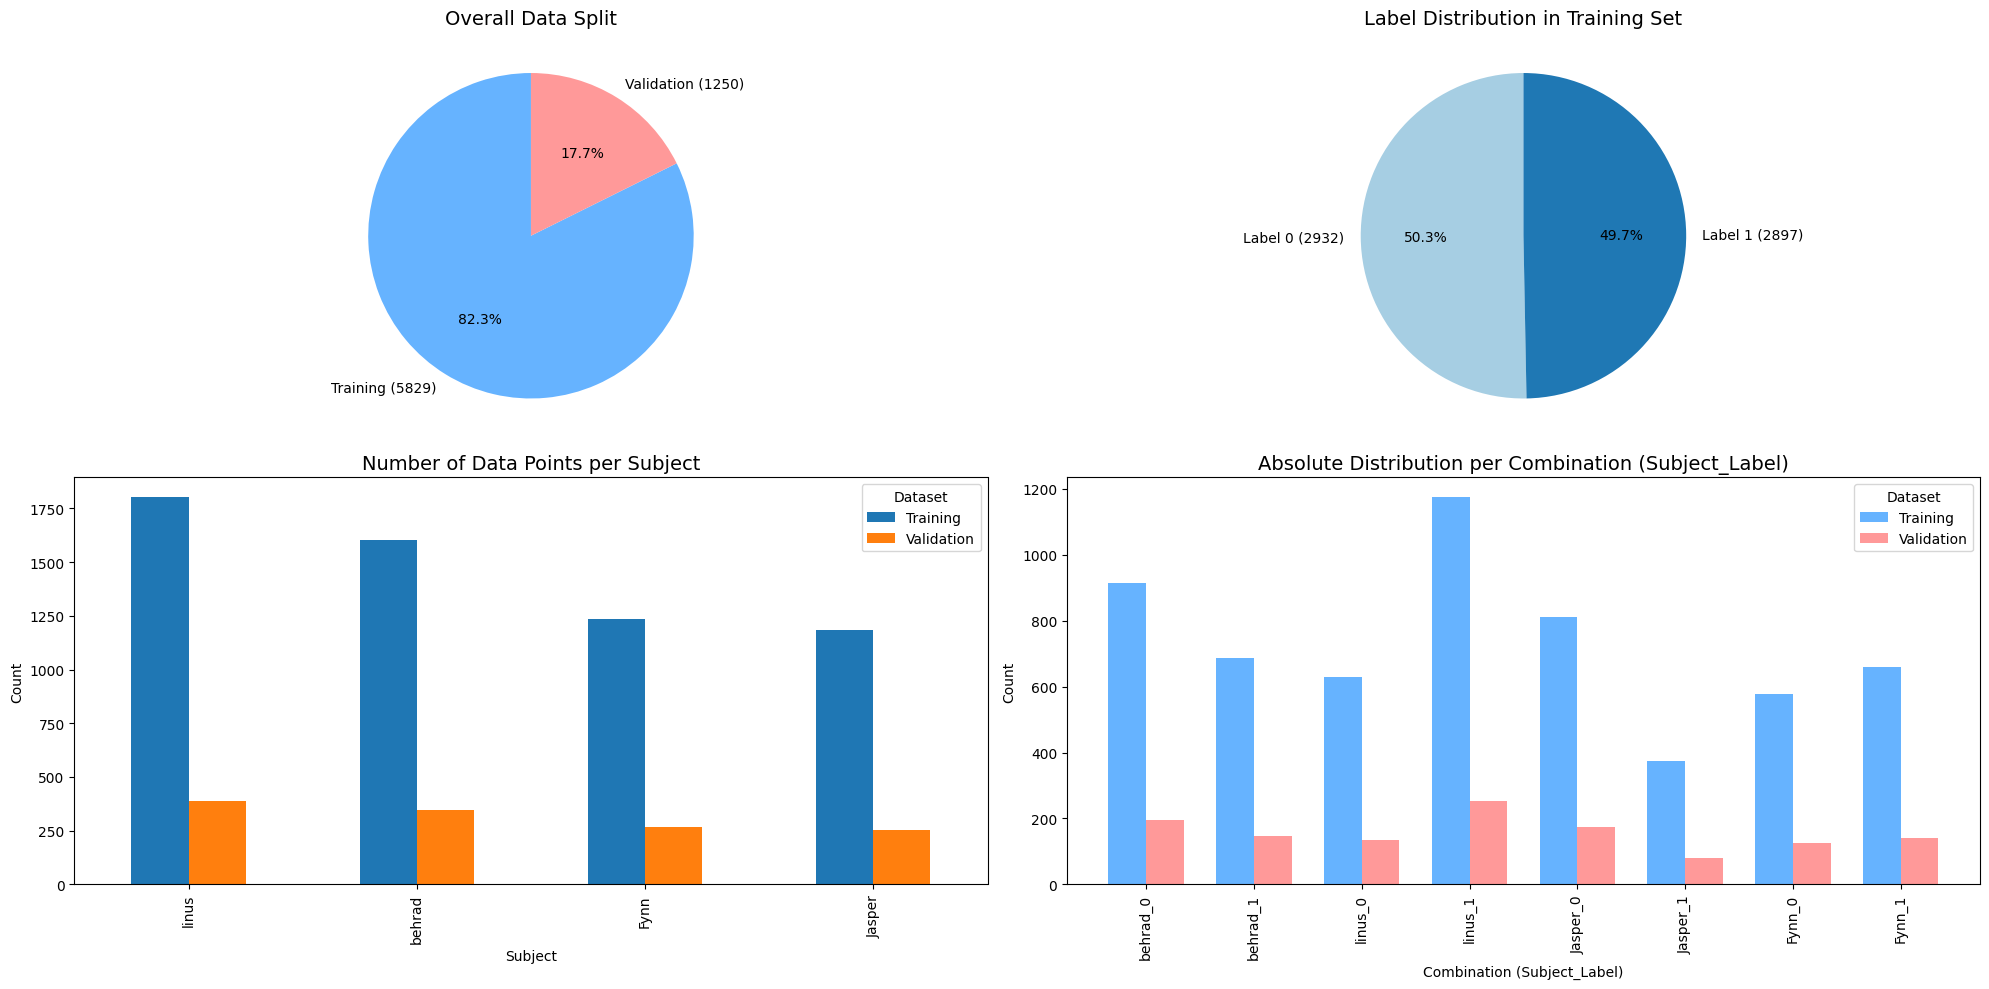


Split Statistics:
Total number of data points: 8333
Training data: 5829 (70.0%)
Validation data: 1250 (15.0%)

Distribution check for each combination:
behrad_0: Training 915/1111 (82.4%), Validation 196/1111 (17.6%) ✓
behrad_1: Training 688/836 (82.3%), Validation 148/836 (17.7%) ✓
linus_0: Training 628/763 (82.3%), Validation 135/763 (17.7%) ✓
linus_1: Training 1176/1428 (82.4%), Validation 252/1428 (17.6%) ✓
Jasper_0: Training 812/986 (82.4%), Validation 174/986 (17.6%) ✓
Jasper_1: Training 373/453 (82.3%), Validation 80/453 (17.7%) ✓
Fynn_0: Training 577/701 (82.3%), Validation 124/701 (17.7%) ✓
Fynn_1: Training 660/801 (82.4%), Validation 141/801 (17.6%) ✓


In [52]:
visualize_split(train_df, val_df, merged_df_split_parts)

In [53]:
#train_df.merge(val_df, left_index=True, right_index=True, how = "inner")

In [54]:
# Set the number of worker processes for loading data. This should be the number of CPUs available.
num_workers = multiprocessing.cpu_count()#//2
batch_size = 128
# Define parameters for DataLoader
data_loader_params = {
    'batch_size': batch_size,  # Batch size for data loading
    'num_workers': num_workers,  # Number of subprocesses to use for data loading
    'persistent_workers': True,  # If True, the data loader will not shutdown the worker processes after a dataset has been consumed once. This allows to maintain the worker dataset instances alive.
    'pin_memory': 'cuda' in device,  # If True, the data loader will copy Tensors into CUDA pinned memory before returning them. Useful when using GPU.
    'pin_memory_device': device if 'cuda' in device else '',  # Specifies the device where the data should be loaded. Commonly set to use the GPU.
}

In [55]:
# Instantiate the dataset
dataset_train = AudioDataset(image_paths=train_df["image_filename"], labels=train_df["label"], transform=train_transform)
dataset_val = AudioDataset(image_paths=val_df["image_filename"], labels=val_df["label"], transform=valid_transform)
dataset_test = AudioDataset(image_paths=test_df["image_filename"], labels=test_df["label"], transform=valid_transform)
# Create a DataLoader
data_loader = DataLoader(dataset_train, **data_loader_params, shuffle=True, drop_last=False)
data_loader_val = DataLoader(dataset_val, **data_loader_params, shuffle=False, drop_last=False)
data_loader_test = DataLoader(dataset_test, **data_loader_params, shuffle=False, drop_last=False)

It is important to note that we are doing a regression task, therefore we need to change the last layer to have only one output feature.

### Model training

In [56]:
model = model.to(device)

In [57]:
def get_warmup_scheduler(optimizer, num_warmup_steps, total_steps):
    """
    Returns a scheduler with a linear warmup phase.

    :param optimizer: Optimizer to adjust the learning rate for.
    :param num_warmup_steps: Number of steps for the warmup phase.
    :param total_steps: Total number of training steps.
    """
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, float(total_steps - current_step) / float(max(1, total_steps - num_warmup_steps)))

    return LambdaLR(optimizer, lr_lambda)

In [58]:
class WarmupDecayScheduler(optim.lr_scheduler._LRScheduler):
    def __init__(self, optimizer, warmup_steps, total_steps, min_lr=0, last_epoch=-1):
        self.warmup_steps = warmup_steps
        self.total_steps = total_steps
        self.min_lr = min_lr
        super(WarmupDecayScheduler, self).__init__(optimizer, last_epoch)

    def get_lr(self):
        current_step = self.last_epoch + 1
        if current_step < self.warmup_steps:
            # Warmup phase: Linear increase
            scale = current_step / self.warmup_steps
        else:
            # Decay phase: Cosine decay
            decay_steps = self.total_steps - self.warmup_steps
            scale = max(
                0,
                0.5 * (1 + math.cos(math.pi * (current_step - self.warmup_steps) / decay_steps))
            )
        return [
            self.min_lr + (base_lr - self.min_lr) * scale
            for base_lr in self.base_lrs
        ]

In [59]:
lr = 5e-4
epochs = 30

# Calculate the weights for each class
label_counts = Counter(train_df['label'])
num_neg = label_counts[0]
num_pos = label_counts[1]
pos_weight = torch.tensor([num_neg / num_pos], dtype=torch.float).to(device)


# Define loss and optimizer
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
metric = BinaryAccuracy()

# Define warmup and total steps
total_steps = len(data_loader) * epochs
warmup_ratio = 0.1
num_warmup_steps = int(warmup_ratio * total_steps)

#optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8,weight_decay = 1e-6)
optimizer = torch.optim.AdamW(model.parameters(), lr=lr, eps=1e-8)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True, weight_decay=0.01)

# Create scheduler
warmup = get_warmup_scheduler(optimizer, num_warmup_steps, total_steps)
#lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,eta_min=1e-5, T_0 = int(epochs*0.2), T_mult = 1)
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, max_lr=5e-4, steps_per_epoch=len(data_loader), pct_start=warmup_ratio, anneal_strategy='cos', cycle_momentum=True, base_momentum=0.85, div_factor=25, final_div_factor=1e4, epochs=epochs)
#lr_scheduler = WarmupDecayScheduler(optimizer, num_warmup_steps, total_steps, min_lr=5e-6)


In [60]:
pos_weight

tensor([1.0121], device='cuda:0')

In [61]:
#step_size = 3
#gamma = 0.5

# Scheduler
#scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

In [62]:
# Function to run a single training/validation epoch
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, criterion, loss_array, accuracy_array, is_training):
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()
    iters = len(dataloader)
    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch
    epoch_loss = 0
    epoch_accuracy = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc="Train" if is_training else "Eval")

    # Iterate over data batches
    for batch_id, (inputs, labels) in enumerate(dataloader):
        # Move inputs and labels to the specified device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)


        # Forward pass
        outputs = model(inputs).squeeze()  # Get predictions
        loss = criterion(outputs, labels)

        # Update the performance metric
        metric.update(outputs.detach().cpu().squeeze(), labels.detach().cpu())

        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            # Zero the parameter gradients
            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item
        epoch_accuracy = metric.compute().item()
        # Update progress bar
        progress_bar.set_postfix(Accuracy=epoch_accuracy,
                                 loss=loss_item,
                                 avg_loss=epoch_loss/(batch_id+1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message
    loss_array.append(epoch_loss / (batch_id + 1))
    accuracy_array.append(epoch_accuracy)
    progress_bar.close()
    return epoch_loss / (batch_id + 1)


# Main training loop
def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, criterion, checkpoint_path, use_scaler=False):
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = GradScaler() if device.type == 'cuda' and use_scaler else None
    best_loss = float('inf')
    patience = 15
    patience_counter = 0
    best_model_path = "best_model.pth"

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, criterion, train_losses, train_accuracies,  is_training=True)
        # Run validation epoch and compute validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, criterion, val_losses, val_accuracies, is_training=False)

        # If current validation loss is lower than the best one so far, save model and update best loss
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print("🔥 Best model saved!")
            metric_value = metric.compute().item()
            
            
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
            }

            # Save best_loss and metric_value in a JSON file
            #with open(Path(checkpoint_path.parent/'training_metadata.json'), 'w') as f:
            #    json.dump(training_metadata, f)
        else:
                patience_counter += 1
                print(f"Early stopping patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⏹️ Early stopping triggered. Training stopped.")
            break
    # **Load Best Model for Final Evaluation**
    model.load_state_dict(torch.load(checkpoint_path))
    print("✅ Loaded best model.")
    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

    return train_losses, val_losses, train_accuracies, val_accuracies

In [63]:
def run_epoch(model, dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch_id, criterion, loss_array, accuracy_array, is_training):
    """Führt eine Trainings- oder Evaluierungsepoche durch."""
    # Set model to training mode if 'is_training' is True, else set to evaluation mode
    model.train() if is_training else model.eval()

    # Reset the performance metric
    metric.reset()
    # Initialize the average loss for the current epoch
    epoch_loss = 0
    epoch_accuracy = 0
    # Initialize progress bar with total number of batches in the dataloader
    progress_bar = tqdm(total=len(dataloader), desc=f"Train {epoch_id + 1}" if is_training else f"Eval {epoch_id + 1}")

    # Iterate over data batches
    for batch_id, (inputs, labels) in enumerate(dataloader):
        # Move inputs and labels to the specified device (e.g., GPU)
        inputs, labels = inputs.to(device), labels.to(device)

        # Enables gradient calculation if 'is_training' is True
        with torch.set_grad_enabled(is_training):
            # Automatic Mixed Precision (AMP) context manager for improved performance
            with autocast(device_type=device.type):
                outputs = model(inputs) # Forward pass
                outputs = outputs.squeeze(1)
                loss = criterion(outputs, labels)

        # Update the performance metric
        probs = torch.sigmoid(outputs.detach().cpu())
        metric.update(probs, labels.detach().cpu())

        # If in training mode
        if is_training:
            if scaler:
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                old_scaler = scaler.get_scale()
                scaler.update()
                new_scaler = scaler.get_scale()
                if new_scaler >= old_scaler:
                    lr_scheduler.step()
            else:
                loss.backward()
                optimizer.step()
                lr_scheduler.step()
            # Zero the parameter gradients
            optimizer.zero_grad()

        loss_item = loss.item()
        epoch_loss += loss_item
        epoch_accuracy = metric.compute().item()
        # Update progress bar
        progress_bar.set_postfix(Accuracy=epoch_accuracy,
                                 loss=loss_item,
                                 avg_loss=epoch_loss/(batch_id+1),
                                 lr=lr_scheduler.get_last_lr()[0] if is_training else "")
        progress_bar.update()

        # If loss is NaN or infinity, stop training
        if is_training:
            stop_training_message = f"Loss is NaN or infinite at epoch {epoch_id}, batch {batch_id}. Stopping training."
            assert not math.isnan(loss_item) and math.isfinite(loss_item), stop_training_message
    loss_array.append(epoch_loss / (batch_id + 1))
    accuracy_array.append(epoch_accuracy)
    progress_bar.close()
    return epoch_loss / (batch_id + 1)

def train_loop(model, train_dataloader, valid_dataloader, optimizer, metric, lr_scheduler, device, epochs, criterion, checkpoint_path, use_scaler=False):
    """Haupttrainingsfunktion, die den gesamten Trainingsprozess steuert."""
    # Initialize a gradient scaler for mixed-precision training if the device is a CUDA GPU
    scaler = GradScaler() if use_scaler else None
    best_accuracy = 0.0
    patience = 10
    patience_counter = 0

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    # Iterate over each epoch
    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Run training epoch and compute training loss
        train_loss = run_epoch(model, train_dataloader, optimizer, metric, lr_scheduler, device, scaler, epoch, criterion, train_losses, train_accuracies, is_training=True)
        # Run validation epoch and compute validation loss
        with torch.no_grad():
            valid_loss = run_epoch(model, valid_dataloader, None, metric, None, device, scaler, epoch, criterion, val_losses, val_accuracies, is_training=False)

        # If current validation loss is lower than the best one so far, save model and update best loss
        if val_accuracies[-1] > best_accuracy:
            best_accuracy = val_accuracies[-1]
            patience_counter = 0
            torch.save(model.state_dict(), checkpoint_path)
            print("🔥 Best model saved!")
            metric_value = metric.compute().item()
            
            training_metadata = {
                'epoch': epoch,
                'train_loss': train_loss,
                'valid_loss': valid_loss,
                'metric_value': metric_value,
                'learning_rate': lr_scheduler.get_last_lr()[0],
            }
        else:
            patience_counter += 1
            print(f"Early stopping patience: {patience_counter}/{patience}")

        if patience_counter >= patience:
            print("⏹️ Early stopping triggered. Training stopped.")
            break
    # **Load Best Model for Final Evaluation**
    model.load_state_dict(torch.load(checkpoint_path))
    print("✅ Loaded best model.")
    # If the device is a GPU, empty the cache
    if device.type != 'cpu':
        getattr(torch, device.type).empty_cache()

    return train_losses, val_losses, train_accuracies, val_accuracies

In [64]:
checkpoint_path = "best_model.pth"

In [65]:
train_losses, val_losses, train_accuracies, val_accuracies = train_loop(model=model,
                                                                           train_dataloader=data_loader,
                                                                           valid_dataloader=data_loader_val,
                                                                           optimizer=optimizer,
                                                                           metric=metric,
                                                                           lr_scheduler=lr_scheduler,
                                                                           device=torch.device(device),
                                                                           epochs=epochs,
                                                                           criterion = criterion,
                                                                           use_scaler = True,
                                                                           checkpoint_path=checkpoint_path
                                                                           )

<ipython-input-63-53ffedc5cc10>:70: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_scaler else None


Epochs:   0%|          | 0/30 [00:00<?, ?it/s]

Train 1:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 1:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 2:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 2:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 1/10


Train 3:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 3:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 4:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 4:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 5:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 5:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 1/10


Train 6:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 6:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 2/10


Train 7:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 7:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 8:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 8:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 9:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 9:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 1/10


Train 10:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 10:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 11:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 11:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 1/10


Train 12:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 12:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 13:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 13:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 14:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 14:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 15:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 15:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 1/10


Train 16:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 16:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 2/10


Train 17:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 17:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 3/10


Train 18:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 18:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 4/10


Train 19:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 19:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 5/10


Train 20:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 20:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 6/10


Train 21:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 21:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 7/10


Train 22:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 22:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 23:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 23:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 1/10


Train 24:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 24:   0%|          | 0/10 [00:00<?, ?it/s]

🔥 Best model saved!


Train 25:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 25:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 1/10


Train 26:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 26:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 2/10


Train 27:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 27:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 3/10


Train 28:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 28:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 4/10


Train 29:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 29:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 5/10


Train 30:   0%|          | 0/46 [00:00<?, ?it/s]

Eval 30:   0%|          | 0/10 [00:00<?, ?it/s]

Early stopping patience: 6/10
✅ Loaded best model.


<ipython-input-63-53ffedc5cc10>:108: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(checkpoint_path))


The trainings loop was adapted and inspired by the tutorial from Christian Mills about [Fine-Tuning Image Classifiers with PyTorch and the timm library for Beginners](https://christianjmills.com/posts/pytorch-train-image-classifier-timm-hf-tutorial/#preparing-the-data).

In [66]:
def evaluate_model(model, data_loader_val, device, train_losses, val_losses, train_accuracies, val_accuracies):
    """Evaluiert das trainierte Modell und zeigt Metriken an."""
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in data_loader_val:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # Binary case: Apply sigmoid and threshold at 0.5
            probs = torch.sigmoid(outputs.squeeze(1))
            predicted = (probs > 0.5).long()

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_accuracy = 100 * correct / total
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    # Plot Loss and Accuracy
    plt.figure(figsize=(12, 5))

    # Loss Plot
    plt.subplot(1, 2, 1)
    plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', linestyle='-', color='b', label="Train Loss")
    plt.plot(range(1, len(val_losses) + 1), val_losses, marker='s', linestyle='-', color='r', label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    # Accuracy Plot
    plt.subplot(1, 2, 2)
    plt.plot(range(1, len(train_accuracies) + 1), train_accuracies, marker='o', linestyle='-', color='g', label="Train Acc")
    plt.plot(range(1, len(val_accuracies) + 1), val_accuracies, marker='s', linestyle='-', color='orange', label="Val Acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy (%)")
    plt.title("Training & Validation Accuracy")
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_names = ["Awake", "Asleep"]
    disp = ConfusionMatrixDisplay(conf_matrix, display_labels=class_names)
    disp.plot(cmap="Blues")

    plt.title("Confusion Matrix")
    plt.show()

    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))


Test Accuracy: 70.56%


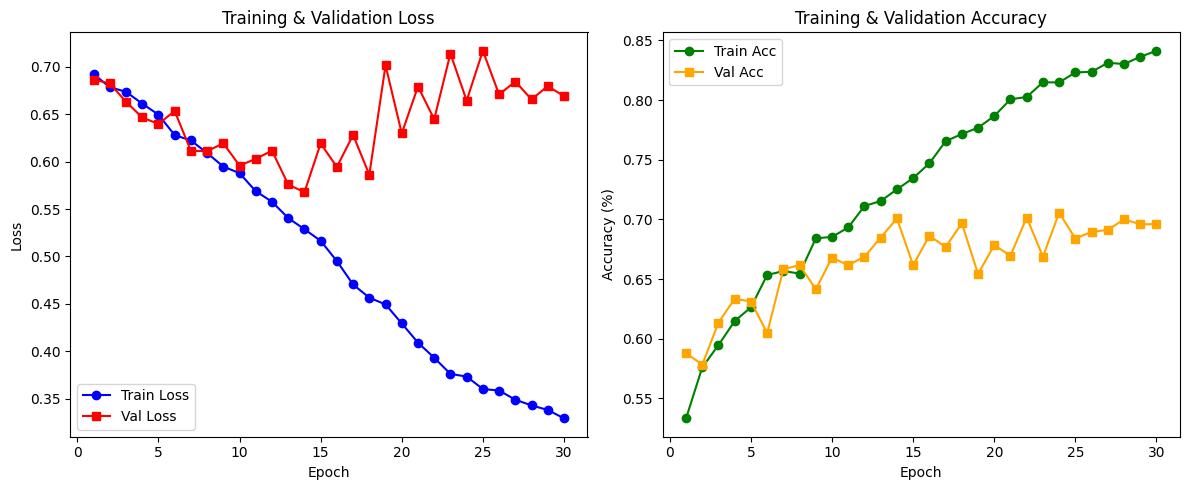

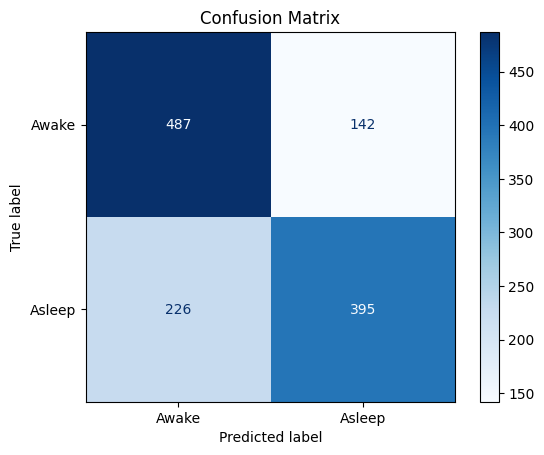

              precision    recall  f1-score   support

       Awake     0.6830    0.7742    0.7258       629
      Asleep     0.7356    0.6361    0.6822       621

    accuracy                         0.7056      1250
   macro avg     0.7093    0.7052    0.7040      1250
weighted avg     0.7091    0.7056    0.7041      1250



In [67]:
evaluate_model(model, data_loader_val, device, train_losses, val_losses, train_accuracies, val_accuracies)

Test Accuracy: 69.22%


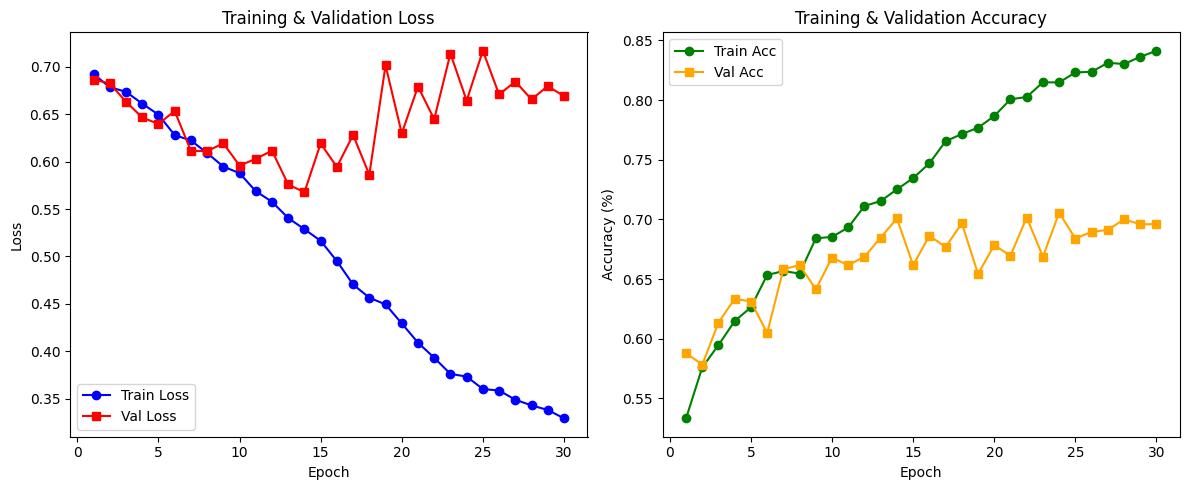

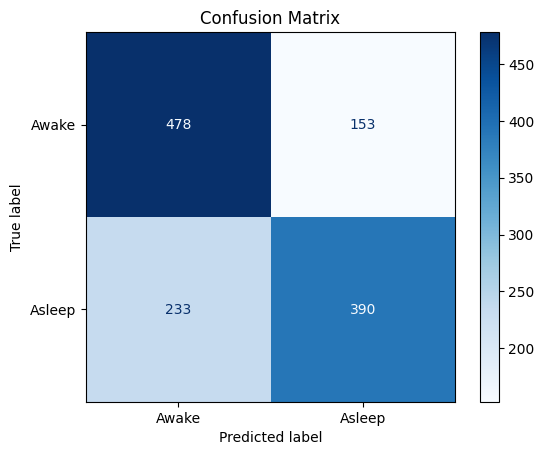

              precision    recall  f1-score   support

       Awake     0.6723    0.7575    0.7124       631
      Asleep     0.7182    0.6260    0.6690       623

    accuracy                         0.6922      1254
   macro avg     0.6953    0.6918    0.6907      1254
weighted avg     0.6951    0.6922    0.6908      1254



In [68]:
evaluate_model(model, data_loader_test, device, train_losses, val_losses, train_accuracies, val_accuracies)